## Импорт библиотек

In [1]:
# Для построения пайплайна обучения используется lightautoml, который конфликтуает с новой версией pandas. Поэтому
!pip uninstall pandas -y
!pip install --upgrade pip > installations.txt
!pip uninstall torch -y > installations.txt # конфликтует 
!pip install torch==2.0.0 > installations.txt
!pip install pandas==1.4.3 pyarrow yellowbrick polars transformers nltk gensim lightautoml > installations.txt
!pip install --upgrade -q wandb > installations.txt

Found existing installation: pandas 2.2.0


Uninstalling pandas-2.2.0:


  Successfully uninstalled pandas-2.2.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0 requires torch==2.1.0, but you have torch 2.0.0 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.0.0 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.0.0 which is incompatible.
torchvision 0.16.0 requires torch==2.1.0, but you have torch 2.0.0 which is incompatible.


In [2]:
# for dataframe
import polars as pl
import numpy as np
import pyarrow as pa
import pandas as pd

# for system
import os
import time
import sys

# for metric
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# for demention decrease
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# for common functions
from collections import OrderedDict
from collections import Counter
from kaggle_secrets import UserSecretsClient
from copy import deepcopy as copy
from typing import Tuple, List

# for monitoring of models
import wandb

# for machine learning
from lightautoml.reader.base import PandasToPandasReader
from lightautoml.tasks import Task
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.report.report_deco import ReportDeco

# my functions
sys.path.append('/kaggle/input/next-orders')
from my_functions import MarketDataProcessor

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class MarketDataProcessor:
    """_Преобразования тренировочного датасета из задачи recsys в binary_"""

    def __init__(self, train: pd.DataFrame, test: pd.DataFrame, k: int = 25):
        """
        Инициализирует объект с заданными необработанными данными,
        дополнительными данными и необязательным значением k.

        Parameters:
            train (pd.DataFrame): история покупок пользователей в формате
            (user_id `int`| order_completed_at `datetime` |	cart `int`).
            test (pd.DataFrame): пустой сабмит (id `str: user_id;cart`| target `int`).
            k (int, необязательно): значение k для инициализации. По умолчанию 25.

        Returns:
            None
        """
        self.train_data = train
        self.test_data = test
        self.k = k
        self.filtered_train = None
        self.filtered_test = None
        self.proportion = None
        self.ohe_data = None
        self.processed_data = None

    def filter_train_data(self) -> Tuple[pd.DataFrame, pd.DataFrame, float]:
        """
        Фильтрует необработанные данные на основе частоты появления пользо\
        Returns:
            Tuple[pd.DataFrame, pd.DataFrame, float]: Отфильтрованные данные истории покупок по заданному условию k, отфильтрованный датафрейм по test, и процент наблюдений, используемых в итоге для обучения.
        """
        users = map(int, (x.split(";")[0] for x in self.test_data["id"]))
        user_counts = Counter(users)
        frequent_users = {user for user, count in user_counts.items() if count > self.k}
        test_users = {user for user, _ in user_counts.items()}
        self.filtered_train = self.train_data[
            self.train_data["user_id"].isin(frequent_users)
        ]
        self.filtered_test = self.train_data[
            self.train_data["user_id"].isin(test_users)
        ]
        total_count = sum(user_counts.values())
        frequent_count = sum(
            count for user, count in user_counts.items() if user in frequent_users
        )
        self.proportion = frequent_count / total_count

        return self.filtered_train, self.filtered_test, self.proportion

    def get_dummies_matrix(self):
        """
        Вовращает dummies матрицу для категорий(cart). Таким образом для каждой категории, если она была в установленное время в заказе у пользователя, будет 1
        Returns:
            (tpl.DataFrame).
        """
        train_train = pd.get_dummies(self.train_data, columns=["cart"])
        train_train = pl.from_pandas(train_train)
        train_train = train_train.group_by(["user_id", "order_completed_at"]).max()
        self.ohe_data = train_train.sort(["user_id", "order_completed_at"])

    def generate_time_features(self):
        """
        Генерирует временные фичи на основе столбца order_completed_at.
        Returns:
            pl.DataFrame: Обработанный DataFrame для train.
        """

        # Вычисление переменных времени
        self.ohe_data = self.ohe_data.with_columns(
            pl.col("order_completed_at").str.to_datetime()
        )
        self.ohe_data = self.ohe_data.with_columns(
            [
                (pl.col("user_id").cum_count() - pl.lit(1))
                .over(["user_id"])
                .alias("order_number"),
                pl.col("order_completed_at").dt.weekday().alias("weekday"),
                pl.col("order_completed_at").dt.month().alias("month"),
            ]
        )
        self.processed_data = self.ohe_data.drop("order_completed_at")

    def compile_dataset(self, history_flag: int = 0) -> pd.DataFrame:
        """
        Компилирует историю заказов в укомплектованный тренировочный DataFrame "Train".

        Args:
            history_flag (int): Флаг 0 - тренировочный датасет,
                                1 - общий (тестовый) датасет без таргета.

        Returns:
            pd.DataFrame: X + Y for model/ or just X.
        """
        _, _, last_order = self._separate_last_order()

        train_tmp, val_data = self._split_train_and_valid(last_order)

        train_set = self._transform_to_long_format(train_tmp, history_flag)

        order_number_df, dl_tmp = self._calculate_order_and_category_counts(
            train_set, val_data, history_flag
        )

        train_set = self._join_order_and_category_counts(
            train_set, order_number_df, dl_tmp
        )

        train_set = self._calculate_ratings(train_set)

        rating_per_weekday = self._calculate_rating_per_time(train_set, "weekday")
        rating_per_month = self._calculate_rating_per_time(train_set, "month")

        train_set = self._join_rating_per_time(
            train_set,
            rating_per_weekday,
            rating_per_month,
        )

        if not history_flag:
            train_set = self._join_target(train_set, val_data)
            
        train_set = train_set.to_pandas()
        train_set["id"] = train_set["id"].str.replace("cart_", "")
        train_set["category"] = train_set["category"].str.replace("cart_", "")

        return train_set

    def _separate_last_order(self):
        """
        This function separates the last order from the processed data
        and returns grouped, merged, and last_order.
        """
        grouped = self.processed_data.group_by("user_id").agg(
            pl.max("order_number").alias("max_order_number")
        )
        merged = self.processed_data.join(grouped, on="user_id")
        last_order = merged["max_order_number"] == merged["order_number"]
        return grouped, merged, last_order

    def _split_train_and_valid(self, last_order):
        """
        Splits the processed data into training and validation sets based on the last order.

        Parameters:
        - last_order: boolean array indicating whether each record is part of the last order

        Returns:
        - train_tmp: training data excluding the last order
        - val_data: validation data excluding specific time-related columns
        """
        train_tmp = self.processed_data.filter(~last_order)
        val_data = self.processed_data.filter(last_order).drop(
            "hour", "week", "weekday", "day", "month", "year"
        )
        return train_tmp, val_data

    def _transform_to_long_format(self, train_tmp, history_flag):
        """
        Transforms the input data into long format, based on the 'history_flag' parameter.
        Parameters:
            train_tmp: the input data frame
            history_flag: a flag indicating whether to use the 'train_tmp' or 'self.processed_data'
        Returns:
            train_melt: the data frame in long format
        """
        if not history_flag:
            train_melt = train_tmp.drop("order_number").melt(
                id_vars=["user_id", "weekday", "month"],
                variable_name="category",
                value_name="ordered",
            )
        elif history_flag == 1:
            train_melt = self.processed_data.drop("order_number").melt(
                id_vars=["user_id", "weekday", "month"],
                variable_name="category",
                value_name="ordered",
            )
        else:
            print("Invalid history flag. Exiting...")
            sys.exit()
        return train_melt

    def _calculate_order_and_category_counts(self, train_set, val_data, history_flag):
        """
        Calculate order and category counts based on the provided training
        and validation data and a history flag.

        Args:
            train_set: The training dataset.
            val_data: The validation data.
            history_flag: Flag indicating whether to consider historical data.

        Returns:
            order_number_df: DataFrame containing user IDs and order numbers.
            dl_tmp: Aggregated DataFrame with category and ordered item counts.
        """
        order_number_df = val_data.select(["user_id", "order_number"]).unique()
        dl_tmp = train_set.group_by("category").agg(pl.col(["ordered"]).sum())
        if history_flag == 1:
            order_number_df = order_number_df.with_columns(pl.col("order_number") + 1)
            dl_tmp = train_set.group_by("category").agg(pl.col(["ordered"]).sum() + 1)
        return order_number_df, dl_tmp

    def _join_order_and_category_counts(self, train_set, order_number_df, dl_tmp):
        """
        Joins order and category counts to the train_set and returns the updated train_set.

        Parameters:
        - train_set: The original train set dataframe.
        - order_number_df: The dataframe containing order number information.
        - dl_tmp: The temporary dataframe used for joining category information.

        Returns:
        - train_set: The updated train set dataframe.
        - unique_users_count: unique users count
        """
        train_set = train_set.join(order_number_df, on="user_id").rename(
            {"order_number": "total_order_num"}
        )
        train_set = train_set.join(dl_tmp, on="category").rename(
            {"ordered_right": "total_order_in_cat"}
        )
        return train_set

    def _calculate_ratings(self, train_set):
        """
        Calculate the rating statistics for the train set and return the modified train set.
        """
        unique_users_count = train_set.select("user_id").n_unique()
        unique_cat_count = train_set.select("category").n_unique()
        train_set = train_set.with_columns(
            [
                (pl.col("ordered") / pl.col("total_order_num")).alias("rating"),
                (
                    pl.col("total_order_num")
                    * (pl.col("total_order_in_cat") / unique_users_count)
                ).alias("total_rating"),
                (
                    pl.col("total_order_num")
                    * (pl.col("total_order_in_cat") / unique_cat_count)
                ).alias("total_rating_cat"),
                (pl.col("user_id").cast(pl.Utf8) + ";" + pl.col("category")).alias(
                    "id"
                ),
            ]
        )
        train_set = train_set.group_by("user_id", "category", "id").agg(
            pl.col(["weekday"]).mean().name.suffix("_mean"),
            pl.col(["weekday"]).max().name.suffix("_max"),
            pl.col(["weekday"]).min().name.suffix("_min"),
            pl.col(["weekday"]).std().name.suffix("_std"),
            pl.col(["month"]).mean().name.suffix("_mean"),
            pl.col(["month"]).max().name.suffix("_max"),
            pl.col(["month"]).min().name.suffix("_min"),
            pl.col(["month"]).std().name.suffix("_std"),
            pl.col(["total_rating"]).mean().name.suffix("_mean"),
            pl.col(["total_rating"]).max().name.suffix("_max"),
            pl.col(["total_rating"]).min().name.suffix("_min"),
            pl.col(["total_rating"]).std().name.suffix("_std"),
            pl.col(["rating"]).mean().name.suffix("_mean"),
            pl.col(["rating"]).max().name.suffix("_max"),
            pl.col(["rating"]).min().name.suffix("_min"),
            pl.col(["rating"]).std().name.suffix("_std"),
            pl.col(["total_rating_cat"]).mean().name.suffix("_mean"),
            pl.col(["total_rating_cat"]).max().name.suffix("_max"),
            pl.col(["total_rating_cat"]).min().name.suffix("_min"),
            pl.col(["total_rating_cat"]).std().name.suffix("_std"),
            pl.col(["ordered"]).mean().name.suffix("_mean"),
            pl.col(["ordered"]).max().name.suffix("_max"),
            pl.col(["ordered"]).min().name.suffix("_min"),
            pl.col(["ordered"]).std().name.suffix("_std"),
            pl.col(["total_order_in_cat"]).mean().name.suffix("_mean"),
            pl.col(["total_order_in_cat"]).max().name.suffix("_max"),
            pl.col(["total_order_in_cat"]).min().name.suffix("_min"),
            pl.col(["total_order_in_cat"]).std().name.suffix("_std"),
            pl.col(["total_order_num"]).mean().name.suffix("_mean"),
            pl.col(["total_order_num"]).max().name.suffix("_max"),
            pl.col(["total_order_num"]).min().name.suffix("_min"),
            pl.col(["total_order_num"]).std().name.suffix("_std"),
        )
        return train_set

    def _calculate_rating_per_time(self, train_set, time_column):
        """
        Calculate rating per time for the given train set and time column.

        Parameters:
            train_set (DataFrame): The input train set data.
            time_column (str): The name of the time column.

        Returns:
            DataFrame: The calculated rating per time.
        """
        rating_per_time = train_set.group_by([f"{time_column}_mean", "user_id"]).agg(
            ((pl.col("total_rating_mean").mean()) * 100).alias(
                f"t_rating_per_{time_column}_mean"
            ),
            ((pl.col("total_rating_mean").std()) * 100).alias(
                f"t_rating_per_{time_column}_std"
            ),
            ((pl.col("total_rating_mean").sum())).alias(
                f"t_rating_per_{time_column}_sum"
            ),
            ((pl.col("total_rating_mean").median()) * 100).alias(
                f"t_rating_per_{time_column}_median"
            ),
            ((pl.col("rating_mean").mean()) * 100).alias(
                f"rating_per_{time_column}_mean"
            ),
            ((pl.col("rating_mean").std()) * 100).alias(
                f"rating_per_{time_column}_std"
            ),
            ((pl.col("rating_mean").sum())).alias(f"rating_per_{time_column}_sum"),
            ((pl.col("rating_mean").median()) * 100).alias(
                f"rating_per_{time_column}_median"
            ),
            ((pl.col("total_rating_cat_mean").mean()) * 100).alias(
                f"tc_rating_per_{time_column}_mean"
            ),
            ((pl.col("total_rating_cat_mean").std()) * 100).alias(
                f"tc_rating_per_{time_column}_std"
            ),
            ((pl.col("total_rating_cat_mean").sum())).alias(
                f"tc_rating_per_{time_column}_sum"
            ),
            ((pl.col("total_rating_cat_mean").median()) * 100).alias(
                f"tc_rating_per_{time_column}_median"
            ),
        )
        return rating_per_time

    def _join_rating_per_time(
        self,
        train_set,
        rating_per_weekday,
        rating_per_month,
    ):
        """
        Joins rating data per time period to the given train_set dataframe using the
        provided rating data per hour, per weekday, per day, and per month.

        Args:
            train_set: The input train_set dataframe to which the rating data will be joined.
            rating_per_weekday: The dataframe containing rating data per weekday.
            rating_per_month: The dataframe containing rating data per month.

        Returns:
            The train_set dataframe with rating data joined for each time period.
        """
        train_set = train_set.join(rating_per_month, on=["month_mean", "user_id"])
        train_set = train_set.join(
            rating_per_weekday,
            on=["weekday_mean", "user_id"],
        )
        return train_set

    def _join_target(self, train_set, val_data):
        """
        Joins the target data from the validation set to the training
        set based on user_id and category.
        Parameters:
            train_set: The training set DataFrame.
            val_data: The validation set DataFrame.
        Return:
            The updated training set DataFrame with the target data joined.
        """
        valid_melt = val_data.drop(
            "order_number",
        ).melt(
            id_vars=[
                "user_id",
            ],
            variable_name="category",
            value_name="target",
        )
        train_set = train_set.join(valid_melt, on=["user_id", "category"])
        return train_set


## Препроцессинг данных

____________________________________________________
Использовался ноутбук с TPU и RAM 300GB, чтобы не испытывать проблем с памятью во время операционных обработок датасета.

In [4]:
# tmp импорт в pandas
raw = pd.read_csv('../input/sbermarket-internship-competition/train.csv')
sub = pd.read_csv('../input/sbermarket-internship-competition/sample_submission.csv', sep = ",")

# Приведение столбца 'cart' к int
raw['cart'] = raw['cart'].astype(int)

mk_data = MarketDataProcessor(raw, sub)

# Отбрасываем выбросы - юзеров с малым количеством товаров в истории их заказов
filtered_raw, filtered_sub, proportion = mk_data.filter_train_data()
print(f"Процент наблюдений, используемый для тренировки: {proportion:.2f}%")

Процент наблюдений, используемый для тренировки: 0.97%


### Polars ускоряет обработку данных
__________________________________________________
В итоге мы получаем pd датафрейм с усредненным рейтингом id во всем датасете и набор временных переменных, основанных на этой метрике (рейтинг)

In [5]:
%%time
mk_data.get_dummies_matrix()
mk_data.generate_time_features()
Train = mk_data.compile_dataset()

Test = mk_data.compile_dataset(history_flag = 1)

CPU times: user 25min 13s, sys: 8min 7s, total: 33min 20s
Wall time: 3min 2s


### X / Y 

In [6]:
x_cols = Train.select_dtypes(include=['int', 'int8', 'int32', 'uint32', 'uint8', 'float']).drop(columns = ['target'], axis = 1).columns.tolist()
x_cols_pca = Train.select_dtypes(include=['int', 'int8', 'int32', 'uint32', 'uint8', 'float']).drop(columns = ['user_id', 'target'], axis = 1).columns.tolist()
print(x_cols)
y_cols = ['target']
print(y_cols)

['user_id', 'weekday_mean', 'weekday_max', 'weekday_min', 'weekday_std', 'month_mean', 'month_max', 'month_min', 'month_std', 'total_rating_mean', 'total_rating_max', 'total_rating_min', 'total_rating_std', 'rating_mean', 'rating_max', 'rating_min', 'rating_std', 'total_rating_cat_mean', 'total_rating_cat_max', 'total_rating_cat_min', 'total_rating_cat_std', 'ordered_mean', 'ordered_max', 'ordered_min', 'ordered_std', 'total_order_in_cat_mean', 'total_order_in_cat_max', 'total_order_in_cat_min', 'total_order_in_cat_std', 'total_order_num_mean', 'total_order_num_max', 'total_order_num_min', 'total_order_num_std', 't_rating_per_month_mean', 't_rating_per_month_std', 't_rating_per_month_sum', 't_rating_per_month_median', 'rating_per_month_mean', 'rating_per_month_std', 'rating_per_month_sum', 'rating_per_month_median', 'tc_rating_per_month_mean', 'tc_rating_per_month_std', 'tc_rating_per_month_sum', 'tc_rating_per_month_median', 't_rating_per_weekday_mean', 't_rating_per_weekday_std', 't_

### Добавляем главные компоненты

In [7]:
scaler = RobustScaler()

s_Train = Train.copy()
s_Test = Test.copy()
s_Train[x_cols_pca] = scaler.fit_transform(s_Train[x_cols_pca])
s_Test[x_cols_pca] = scaler.transform(s_Test[x_cols_pca])

pca = PCA(n_components=10)

s_Train_pca = pca.fit_transform(s_Train[x_cols])
s_Test_pca = pca.transform(s_Test[x_cols])

Train_pca = pd.DataFrame(s_Train_pca, columns=[f'pc{i+1}' for i in range(s_Train_pca.shape[1])])
Test_pca = pd.DataFrame(s_Test_pca, columns=[f'pc{i+1}' for i in range(s_Train_pca.shape[1])])

s_Train[Train_pca.columns.to_list()] = Train_pca
s_Test[Test_pca.columns.to_list()] = Test_pca

### Кластеризация id(юзер-категория)

Elbow Method to determine the number of clusters for id and target:


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


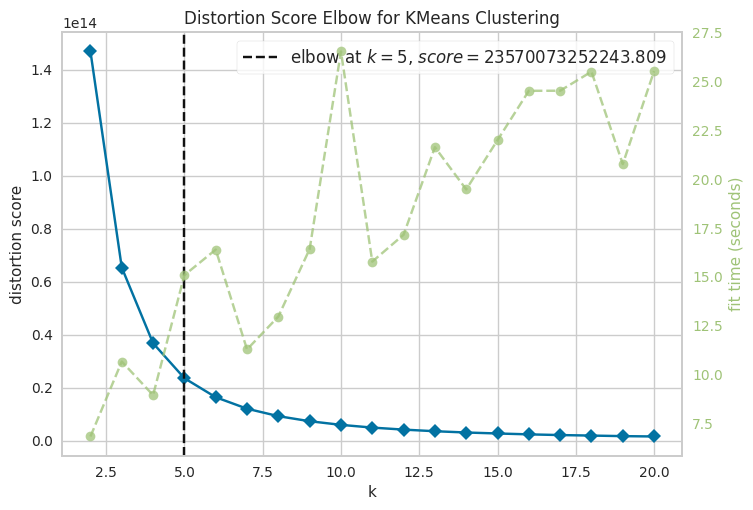

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=20, random_state=4), k=(2, 21))

In [8]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

print('Elbow Method to determine the number of clusters for id and target:')
kelbow_visualizer(KMeans(random_state=4), 
                  Train_pca, 
                  k=(2,21))


In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
cluster = kmeans.fit_predict(Train_pca)
test_cluster = kmeans.predict(Test_pca)
s_Train["Clusters"] = cluster
s_Test["Clusters"] = test_cluster

### Сохранение данных в parquet

In [10]:
# Train.to_parquet('Train.parquet', index=False)
s_Train.to_parquet('s_Train.parquet', index=False)
s_Test.to_parquet('s_Test.parquet', index=False)

In [11]:
# s_Train = pd.read_parquet('/kaggle/input/next-orders/s_Train.parquet')
# s_Test = pd.read_parquet('/kaggle/input/next-orders/s_Test.parquet')

## LightAutoML пайплайн


In [12]:
# Train_set, Valid_set = train_test_split(Train, test_size = TEST_SIZE,
#                                         stratify = None, random_state = 23)
# Train_set.reset_index(drop=True, inplace=True)
# Valid_set.reset_index(drop=True, inplace=True)

In [13]:
# def f1 (real, pred, **kwargs):
#     return f1_score(real, (pred > 0.2).astype(int), **kwargs)

# N_THREADS = 2
# N_FOLDS = 5
# RANDOM_STATE = 42
# TEST_SIZE = 0.2
# TARGET_NAME = 'target'
# ROLES = {'target': TARGET_NAME, 'drop': ['id', 'user_id', 'category'], 'category': ['Clusters']}
# TASK = Task('binary', metric = f1)

# reader = PandasToPandasReader(TASK, cv=N_FOLDS, random_state=RANDOM_STATE)

# lama_params = {
#     "task": TASK,
#     "cpu_limit": N_THREADS,
#     "reader_params": {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
# }
# default_nn_params = {
#     "bs": 128, "num_workers": 0, "path_to_save": None, "n_epochs": 1, "freeze_defaults": True
# }


### Weight and Biasses мониторинг моделей

In [14]:
# user_secrets = UserSecretsClient()
# wandb_api = user_secrets.get_secret("wandb_api") 

# wandb.login(key=wandb_api)
# wandb.login()

# CONFIG = dict (
#     lama_params,
#     general_params = {"use_algos": [["linear_12", "lgbm", "denselight"]]},
#     tuning_params = {'max_tuning_iter': 20},
#     lgb_params = {'default_params': {'num_threads': N_THREADS}},
#     nn_params={**default_nn_params,'lr': 0.03},
#     infra = "Kaggle",
#     competition = 'plant-pathology',
#     _wandb_kernel = 'ayut'
# )
# CONFIG['model_name'] = 'lightAutoML-experiments_w_features_1'
# run = wandb.init(project='sber-inter', 
#                  config=CONFIG,
#                  group='lightAutoML', 
#                  job_type='train')

# wandb.config.type = 'lightAutoML'
# wandb.config.kaggle_competition = 'SberMarket Competition'

In [15]:
# %%time 

# # наиболее оптимальный на данный момент пайплайн
# automl = TabularUtilizedAutoML(
#     task = TASK,
#     timeout = 3600*3,
#     cpu_limit = N_THREADS,
#     reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
# )

# # выбранные среди всех наиболее значимые переменные
# train_pred = automl.fit_predict(Train_set[['total_order_in_cat_max',
#  'ordered_mean',
#  'pc2',
#  'weekday_std',
#  'pc9',
#  'pc10',
#  'category',
#  'pc4',
#  'pc5',
#  'pc6',
#  'month_std',
#  'pc3',
#  'week_std',
#  'hour_std',
#  'hour_mean',
#  'pc1',
#  'pc7', 'target']], roles = ROLES, verbose = 2)

# print('Score', "%.5f" % f1(Train_set.target, train_pred.data))
# valid_pred = automl.predict(Valid_set[['total_order_in_cat_max',
#  'ordered_mean',
#  'pc2',
#  'weekday_std',
#  'pc9',
#  'pc10',
#  'category',
#  'pc4',
#  'pc5',
#  'pc6',
#  'month_std',
#  'pc3',
#  'week_std',
#  'hour_std',
#  'hour_mean',
#  'pc1',
#  'pc7', 'target']])
# print('Score on out of folds validation', "%.5f" % f1(Valid_set.target, valid_pred.data))
# # best catboost params 
# # {'task_type': 'CPU', 'thread_count': 4, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.009044636094268511, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'min_data_in_leaf': 7, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
# # best linear
# #
# # best lgbm 
# # {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 105, 'feature_fraction': 0.8625799184703501, 'bagging_fraction': 0.5053328530427746, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 7.265259184516205e-05, 'reg_lambda': 0.621571500507215, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 4, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'min_sum_hessian_in_leaf': 4.636375055852895}
# # best denselight
# # {'num_workers': 0, 'pin_memory': False, 'max_length': 256, 'is_snap': False, 'input_bn': False, 'max_emb_size': 256, 'bert_name': None, 'pooling': 'cls', 'device': 'cpu', 'use_cont': True, 'use_cat': True, 'use_text': False, 'lang': 'en', 'deterministic': True, 'multigpu': False, 'random_state': 42, 'model': 'denselight', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 30, 'snap_params': {'k': 3, 'early_stopping': True, 'patience': 10, 'swa': True}, 'bs': 1024, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': 'Adam', 'opt_params': {'lr': 0.003757084358753148, 'weight_decay': 0}, 'sch': 'ReduceLROnPlateau', 'scheduler_params': {'patience': 5, 'factor': 0.5, 'min_lr': 1e-05}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': 'UniversalDataset', 'tuned': True, 'optimization_search_space': None, 'verbose_bar': False, 'freeze_defaults': True, 'n_out': None, 'hid_factor': [2, 2], 'hidden_size': [512, 256], 'block_config': [2, 2], 'compression': 0.5, 'growth_size': 256, 'bn_factor': 2, 'drop_rate': 0.1, 'noise_std': 0.05, 'num_init_features': None, 'act_fun': 'LeakyReLU', 'use_noise': False, 'use_bn': True, 'embedding_size': 10, 'cat_embedder': 'cat', 'cont_embedder': 'cont', 'stop_by_metric': False, 'tuning_params': {'fit_on_holdout': True, 'max_tuning_iter': 50, 'max_tuning_time': 3600}}

In [16]:
# fast_fi = automl.get_feature_scores('fast', silent=False)
# fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [17]:
# import joblib

# joblib.dump(automl, 'automl_02.pkl')
# # automl=joblib.load('/kaggle/input/next-orders/automl_rd.pkl')

# run = wandb.init(project='sber-inter', 
#                  config=CONFIG,
#                  group='lightAutoML', 
#                  job_type='save_experiment')

# wandb.config.type = 'lightAutoML'
# wandb.config.kaggle_competition = 'SberMarket Competition'

# artifact = wandb.Artifact(name='automl', type='model')
# artifact.add_file('/kaggle/working/automl_01.pkl')
# run.log_artifact(artifact)

# run.finish()

### Нахождение лучшего порогового значения для сепарации 0 и 1

In [18]:
# best_score = 0
# for i in np.arange(0.01, 1.0, 0.01):
#     score = f1 = f1_score(Valid_set.target, (valid_pred.data > i).astype(int))
#     if score > best_score:
#         best_score = score
#         proba_split = i

# print('At i =', "%.2f" % proba_split,'score is : ' "%.5f" % best_score)

In [19]:
# s_Test['target'] = (predictions.data > proba_split).astype(int)
# submit = pd.merge(sub['id'], s_Test[['id', 'target']], on='id')

## Подготовка сабмита

In [20]:
# import csv

# with open('submission02.csv', 'w', newline='') as csvfile:
#     csvwriter = csv.writer(csvfile)
#     csvwriter.writerow(submit.columns)
#     for row in submit.values:
#         csvwriter.writerow(row)